# Week 03
# While my sampler gently weeps

Why we need sampling and how MCMC gets us pretty far.

## Load Libraries

In [1]:
# for reading json files
import json

# numerical libraries
import numpy as np
import scipy as sp
import pystan

# pandas!
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
sns.set(style="whitegrid")

## For some distributions we can sample directly

If our posterior is a nice distribution which has a nice ``scipy`` function that generates samples, then we are off to the races. Otherwise, we have to do a lot more work. To illustrate some possibilities and increase familiarity with statistical programming, we're going to walk through a few examples.

### What if we have to sample from a funky distribution?

Suppose we want to sample from a mixture of normal distributions.

In [8]:
# defining the components of our mixture distribution
# 'loc' is the mean
# 'scale' is the standard deviation
# 'pi' is the proportion of observations belonging to the components, must sum to 1

pdfs = {}
pdfs[1] = {'loc':1,'scale':2,'pi':0.20}
pdfs[2] = {'loc':5,'scale':1,'pi':0.30}
pdfs[3] = {'loc':10,'scale':1,'pi':0.10}
pdfs[4] = {'loc':20,'scale':2,'pi':0.40}

In [3]:
def p_mixture(x,pdf_dict):
    """
    given a value of x and a dictionary of normals,
    return the PDF of the normal mixture distribution
    """
    pdf_value = 0
    
    for p in pdf_dict.keys():
        pdf_value += pdf_dict[p]['pi'] * sp.stats.norm.pdf(x,
                                                           loc=pdf_dict[p]['loc'],
                                                           scale=pdf_dict[p]['scale']
                                                          )
    return pdf_value

In [9]:
# what's the pdf of x = 1.5 ?
p_mixture(1.5,pdfs)

0.03892861648879867

In [38]:
# let's graph it
x = np.linspace(-5,30,1000)
y = p_mixture(x,pdfs)

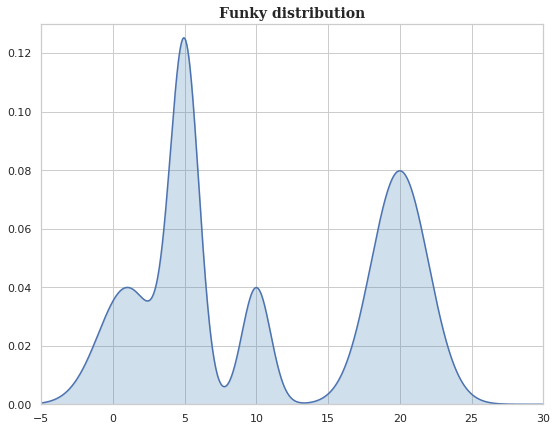

In [434]:
plt.figure(figsize=(9,7))
plt.plot(x,y)
plt.ylim(0,0.13)
plt.xlim(-5,30)
plt.fill_between(x,np.zeros(len(x)),y,color='steelblue',alpha=0.25)
plt.title('Funky distribution',fontsize=14,fontfamily='serif',fontweight='bold');

### Rejection Sampling
Suppose we sample a bunch of random x's and y's in this space. How can we draw samples from our funky distribution?

Algorithm:
1. Sample random x's and y's 
2. For each x, compute PDF at x, f(x). If y <= f(x) then keep the point, otherwise reject.

In [436]:
# let's try 1,000 samples
num_samp = 1000

# sample random values
reject_dict = {}
reject_dict['x'] = sp.stats.uniform.rvs(loc=-5,scale=35,size=num_samp)
reject_dict['y'] = sp.stats.uniform.rvs(loc=0,scale=0.20,size=num_samp)

# is y <= f(x) ?
reject_dict['reject'] = ['kept' if reject_dict['y'][i] <= p_mixture(reject_dict['x'][i],pdfs) else 'rejected' for i in range(len(reject_dict['x']))]
reject_df = pd.DataFrame(reject_dict)

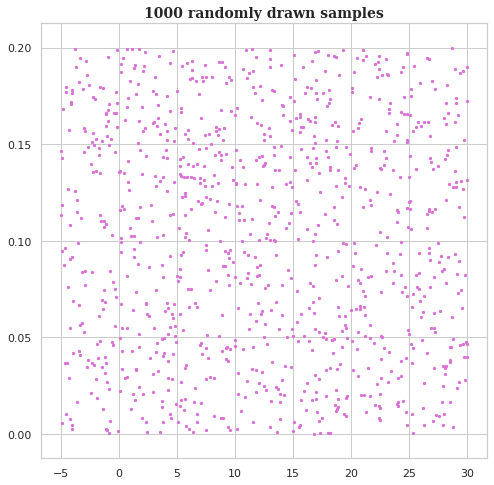

In [437]:
plt.figure(figsize=(8,8))
plt.scatter(reject_dict['x'],reject_dict['y'],s=5,color='orchid')
plt.title(str(num_samp) + ' randomly drawn samples',fontsize=14,fontfamily='serif',fontweight='bold');

In [438]:
# how many did we reject?
reject_df.groupby(['reject']).count()

,x,y
reject,,
kept,163,163
rejected,837,837


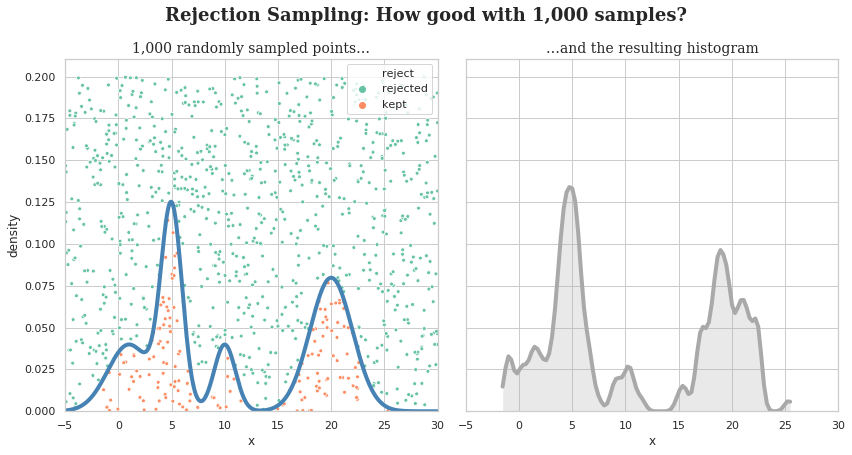

In [439]:
# Initialise the figure and a subplot axes.
num_rows = 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 6),sharex=True,sharey=True)

# overall title
fig.suptitle('Rejection Sampling: How good with 1,000 samples?',
             y=1.05,fontsize=18,fontfamily='serif',fontweight='bold')

# left plot
cmap = sns.color_palette("Set2",2)
ax[0].plot(x,y,lw=4,color='steelblue')
sns.scatterplot(x="x", y="y", hue="reject",data=reject_df,palette=cmap,s=15,ax=ax[0])
ax[0].set_xlim(-5,30)
ax[0].set_ylabel('density')

# right plot
sns.kdeplot(reject_df[reject_df.reject == 'kept'].x,label='',bw=0.05,lw=4,color='darkgray',shade=True,ax=ax[1])
ax[1].set_xlabel('x')

# title
ax[0].set_title('1,000 randomly sampled points...',fontsize=14,fontfamily='serif')
ax[1].set_title('...and the resulting histogram',fontsize=14,fontfamily='serif')

# make the plot prettier
plt.tight_layout()
plt.show();

#### Let's try a lot more

In [440]:
# let's try 100,000 samples
num_samp = 100000

# place in a dictionary
reject_dict = {}
reject_dict['x'] = sp.stats.uniform.rvs(loc=-5,scale=35,size=num_samp)
reject_dict['y'] = sp.stats.uniform.rvs(loc=0,scale=0.20,size=num_samp)

# is y <= f(x) ?
reject_dict['reject'] = ['kept' if reject_dict['y'][i] <= p_mixture(reject_dict['x'][i],pdfs) else 'rejected' for i in range(len(reject_dict['x']))]
reject_df = pd.DataFrame(reject_dict)

In [441]:
# how many did we reject?
reject_df.groupby(['reject']).count()

,x,y
reject,,
kept,14408,14408
rejected,85592,85592


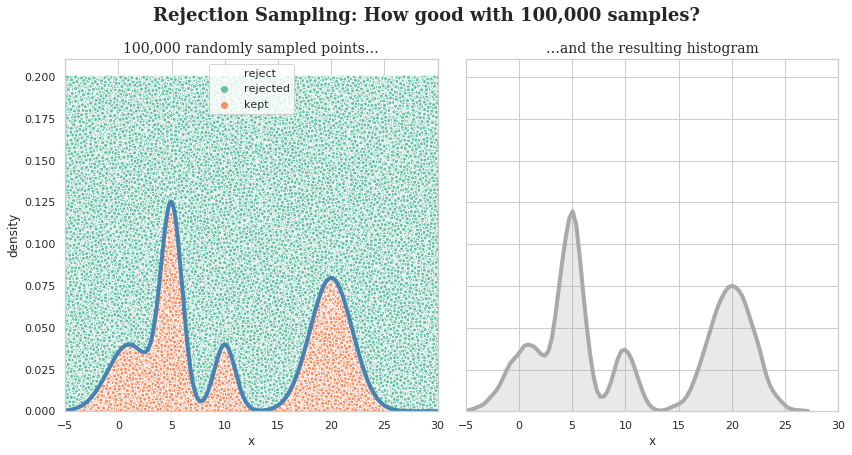

In [442]:
# Initialise the figure and a subplot axes.
num_rows = 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 6),sharex=True,sharey=True)

# overall title
fig.suptitle('Rejection Sampling: How good with 100,000 samples?',
             y=1.05,fontsize=18,fontfamily='serif',fontweight='bold')

# left plot
cmap = sns.color_palette("Set2",2)
ax[0].plot(x,y,lw=4,color='steelblue')
sns.scatterplot(x="x", y="y", hue="reject",data=reject_df,palette=cmap,s=15,ax=ax[0])
ax[0].set_xlim(-5,30)
ax[0].set_ylabel('density')

# right plot
sns.kdeplot(reject_df[reject_df.reject == 'kept'].x,label='',bw=0.05,lw=4,color='darkgray',shade=True,ax=ax[1])
ax[1].set_xlabel('x')

# title
ax[0].set_title('100,000 randomly sampled points...',fontsize=14,fontfamily='serif')
ax[1].set_title('...and the resulting histogram',fontsize=14,fontfamily='serif')

# make the plot prettier
plt.tight_layout()
plt.show();

### Takeaways

* Rejection sampling can work, but it's very expensive computationally. We threw away approximate 85 percent of the draws in these examples.


* We had some idea of what the distribution looked like, so we could narrow our sampling range. What if we had to pick our sampling ranges to be much larger to encompass a more unweildy distribution? 

## Upgrading our sampler: Markov Chains

We need a better way to walk through our posterior distribution. We introduce the idea of Markov Chain Monte Carlo. 

* **Markov** means the current value only depends on the previous value
* **Chain** a series of computations
* **Monte Carlo** random! Stanislaw Ulam's uncle used to gamble his money away in Monte Carlo casino, so it fits...


### Just remember that Monte Carlo is this

<img src="two_dice.jpg" style="height:200px">

### And Markov Chain Monte Carlo is this

<img src="bond.jpg" style="height:400px">

### What does an MCMC algorithm do?

MCMC algorithms allow us to sample from an arbitrary distribution, and they are a pillar of Bayesian computation. In general MCMC algorithms start at a random part of the distribution, then they intelligently walk through the space recording values along the way. 

* What does intelligent mean? We aren't as careless as rejection sampling. 

* How do we know we're done? When our chains reach a stationary distribution.

**Steps to MCMC**
1. Start somewhere, anywhere will do.
2. Propose somewhere to go.
3. Should I stay or should I go now?
4. Either way, propose somewhere new to go.
5. Repeat until you get the picture.

### MCMC algorithms are well known

MCMC algorithms are extremely well studied, and statisticians are comfortable with their properties and behavior in a wide range of scenarios. Statisticians have developed theories that an MCMC chain—under certain conditions—will _always_ converge to the target distribution (in our case, target is the posterior).

### But these are not black boxes that always work

> MCMC is most definitely not a panacea and should be used with caution, almost as a last resort. It is just that we are at the last resort for interesting models.
— Chris Holmes

### However, MCMC expands our modeling space

>An approximate answer to the right problem is worth a good deal more than an exact answer to an approximate
problem. — John Tukey

### Motivating Example: Queen Markov
_example borrowed from *Statistical Rethinking* by McElreath, section 8.1_

To fix ideas, suppose you are Queen Markov, and you govern an island nation consisting of 10 islands. While you're queen for life, it's much easier if you actually visit your subjects, because your subjects agree not to revolt if the Queen visits each island in proportion to its population. 

How can Queen Markov live happily ever after? With Markov Chain Monte Carlo of course!

#### Details

1. The nation consists of 10 islands. 
2. The islands are in a circle.
3. Island 1 has 10 people, island 2 has 20 people, ... and island 10 has 100 people.
4. The Queen can only travel to adjacent islands because the ocean in the middle of her domain is populated by wicked sea monsters.

#### The Queen's Algorithm for Happily Ever After

1. Each week the Queen decides whether to stay put or move to an adjacent island. To decide the next move, the queen flips a coin. 
2. If the coin lands heads, the queen considers moving clockwise. Otherwise, she considers moving counter-clockwise.
3. The Queen computes the ratio between the population of the proposed island and the current island.
4. If this ratio is greater than 1, then she moves to the proposed island.
5. If this ratio is less than 1, then she moves to the proposed island with a probability equal to that ratio.
6. Repeat steps one through five to achieve happily ever after.

### _happily ever after_ coded in Python

In [132]:
def happily_ever_after(pop,start,n_steps):
    """
    Help Queen Markov live happily ever after
    
    provide
    ==============================
    pop     :: np.array of population figures for each island
    start   :: the starting island, integer from 1 to 10
    n_steps :: how many weeks to carry out the algorithm, integer
    
    outputs
    ==============================
    positions :: an array of positions visited by Queen Markov
    """
    
    # max and min positions
    max_island = len(pop) - 1
    
    # starting position is the current one
    current = start
    
    # a memory tape
    positions = np.zeros(n_steps)
    
    # iterate the algorithm
    for i in range(n_steps):
        # record position
        positions[i] = current
                
        # generate a proposal by flipping a coin
        proposal = current + np.random.choice([-1,1])
        
        # stay on the island!
        if proposal < 0:
            proposal = max_island
        elif proposal > max_island:
            proposal = 0
        
        # move?
        prob_move = pop[proposal] / pop[current]
        random_draw = np.random.rand()
        
        if prob_move > 1:
            current = proposal
        elif random_draw < prob_move:
            current = proposal
    
    # return the recording of all islands visited by Queen Markov
    return positions

#### Does it work?

In [133]:
# define population
island_population = np.array([10,20,30,40,50,60,70,80,90,100],dtype=np.float)

In [181]:
# set out on the road my friend
journey = happily_ever_after(island_population,4,100)

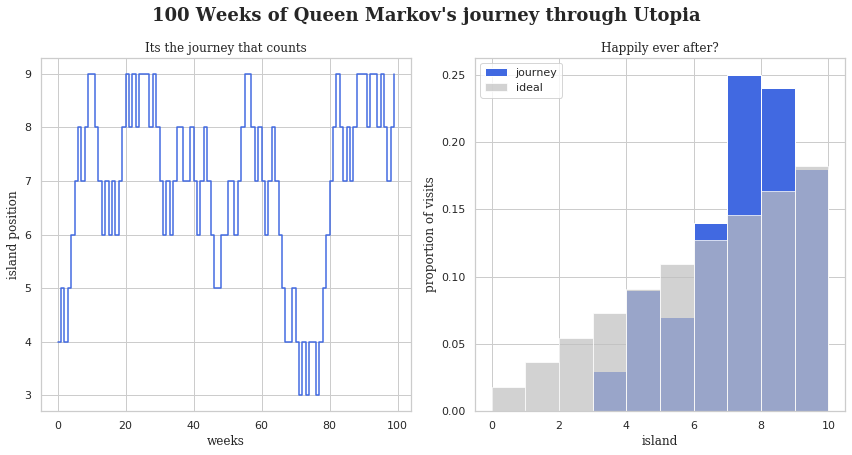

In [182]:
# plot the journey against the ideal visit rate
num_rows = 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 6),sharex=False,sharey=False)

# overall title
fig.suptitle('100 Weeks of Queen Markov\'s journey through Utopia',
             y=1.05,fontsize=18,fontfamily='serif',fontweight='bold')

# left plot
ax[0].step(list(range(len(journey))),journey,where='post',color='royalblue')
ax[0].set_xlabel('weeks',fontfamily='serif')
ax[0].set_ylabel('island position',fontfamily='serif')
ax[0].set_title('Its the journey that counts',fontfamily='serif')

# right plot
ax[1].hist(journey,bins=list(range(11)),density=True,color='royalblue',label='journey')
ax[1].bar(list(range(10)),island_population / sum(island_population),
          color='silver',
          align="edge",
          width=1,
          alpha=0.7,
          label='ideal'
         )
ax[1].set_xlabel('island',fontfamily='serif')
ax[1].set_ylabel('proportion of visits',fontfamily='serif')
ax[1].set_title('Happily ever after?',fontfamily='serif')
ax[1].legend()

# make the plot prettier
plt.tight_layout()
plt.show();

#### The long view

In [173]:
# we're in it to win it!
journey = happily_ever_after(island_population,4,10000)

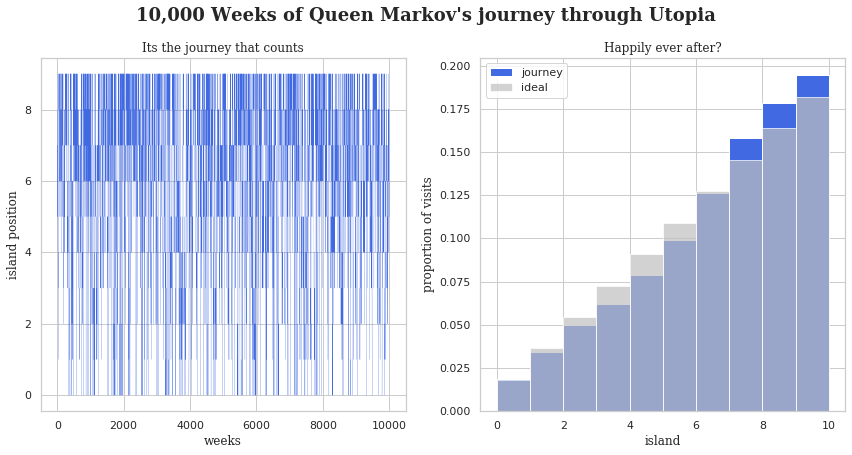

In [180]:
# plot the journey against the ideal visit rate
num_rows = 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 6),sharex=False,sharey=False)

# overall title
fig.suptitle('10,000 Weeks of Queen Markov\'s journey through Utopia',
             y=1.05,fontsize=18,fontfamily='serif',fontweight='bold')

# left plot
ax[0].step(list(range(len(journey))),journey,lw=0.15,where='post',color='royalblue')
ax[0].set_xlabel('weeks',fontfamily='serif')
ax[0].set_ylabel('island position',fontfamily='serif')
ax[0].set_title('Its the journey that counts',fontfamily='serif')

# right plot
ax[1].hist(journey,bins=list(range(11)),density=True,color='royalblue',label='journey')
ax[1].bar(list(range(10)),island_population / sum(island_population),
          color='silver',
          align="edge",
          width=1,
          alpha=0.7,
          label='ideal'
         )
ax[1].set_xlabel('island',fontfamily='serif')
ax[1].set_ylabel('proportion of visits',fontfamily='serif')
ax[1].set_title('Happily ever after?',fontfamily='serif')
ax[1].legend()

# make the plot prettier
plt.tight_layout()
plt.show();

#### Suppose Queen Markov Slays the Sea Monsters

Now suppose Queen Markov slays the sea monsters and can travel to any island. Does this improve her MCMC sampling?

In [183]:
def monsters_banished(pop,start,n_steps):
    """
    Help Queen Markov live happily ever after,
    with the sea monsters gone!
    
    provide
    ==============================
    pop     :: np.array of population figures for each island
    start   :: the starting island, integer from 1 to 10
    n_steps :: how many weeks to carry out the algorithm, integer
    
    outputs
    ==============================
    positions :: an array of positions visited by Queen Markov
    """
    
    # max and min positions
    max_island = len(pop) - 1
    
    # starting position is the current one
    current = start
    
    # a memory tape
    positions = np.zeros(n_steps)
    
    # iterate the algorithm
    for i in range(n_steps):
        # record position
        positions[i] = current
                
        # %%%%% THIS LINE IS NEW %%%%%
        # generate a proposed trip
        proposal = np.random.choice(list(range(len(pop))))
        
        # move?
        prob_move = pop[proposal] / pop[current]
        random_draw = np.random.rand()
        
        if prob_move > 1:
            current = proposal
        elif random_draw < prob_move:
            current = proposal
    
    # return the recording of all islands visited by Queen Markov
    return positions

In [196]:
# we're in it to win it!
improved_journey = monsters_banished(island_population,4,100)

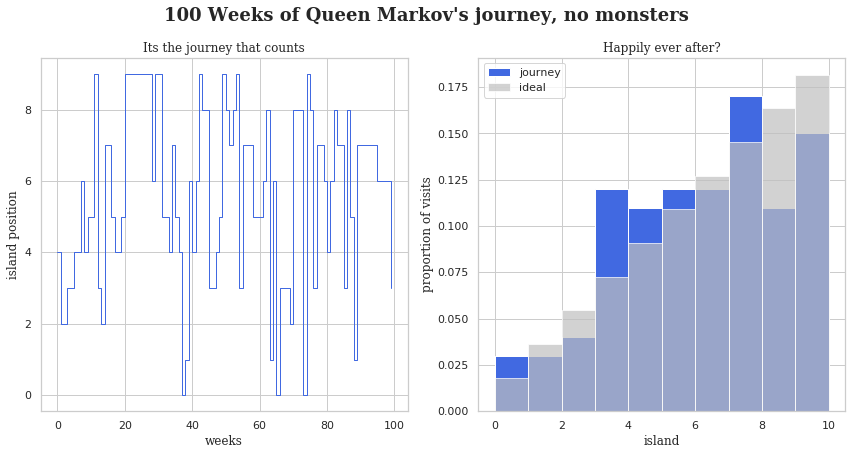

In [198]:
# plot the journey against the ideal visit rate
num_rows = 1
num_cols = 2
fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 6),sharex=False,sharey=False)

# overall title
fig.suptitle('100 Weeks of Queen Markov\'s journey, no monsters',
             y=1.05,fontsize=18,fontfamily='serif',fontweight='bold')

# left plot
ax[0].step(list(range(len(improved_journey))),improved_journey,lw=1,where='post',color='royalblue')
ax[0].set_xlabel('weeks',fontfamily='serif')
ax[0].set_ylabel('island position',fontfamily='serif')
ax[0].set_title('Its the journey that counts',fontfamily='serif')

# right plot
ax[1].hist(improved_journey,bins=list(range(11)),density=True,color='royalblue',label='journey')
ax[1].bar(list(range(10)),island_population / sum(island_population),
          color='silver',
          align="edge",
          width=1,
          alpha=0.7,
          label='ideal'
         )
ax[1].set_xlabel('island',fontfamily='serif')
ax[1].set_ylabel('proportion of visits',fontfamily='serif')
ax[1].set_title('Happily ever after?',fontfamily='serif')
ax[1].legend()

# make the plot prettier
plt.tight_layout()
plt.show();

## Returning to our funky distribution

Can we use the Queen's algorithm to help us sample from our funky distribution?

To do that, we need to slightly alter the code. In the Queen's case, we had a discrete number of places to visit. In this new world we have a continuum. If we change a couple of lines of code, we're there.

#### Barebones MCMC sampler

In [203]:
def funky_walk(mixture_pdf,pdf_dict,start,step_std,n_steps):
    """
    walk through any distribution using
    an MCMC sampler
    
    provide
    ==============================
    mixture_pdf  :: a function that returns the PDF for a given x
    pdf_dict     :: dictionary defining components of mixture distr
    start        :: the starting position, real number
    step_std     :: standard deviation of the step size of proposals
    n_steps      :: how many steps to take
    
    outputs
    ==============================
    positions :: an array of positions visited by our sampler
    
    """

    # starting position is the current one
    current = start
    
    # a memory tape
    positions = np.zeros(n_steps)
    
    # iterate the algorithm
    for i in range(n_steps):
        # record position
        positions[i] = current
        
        # %%%%% THIS LINE IS NEW %%%%%
        # generate a proposed trip
        proposal = current + sp.stats.norm.rvs(loc=0,scale=step_std)
        
        # %%%%% SO IS THIS ONE %%%%%
        # move?
        prob_move = mixture_pdf(proposal,pdf_dict) / mixture_pdf(current,pdf_dict)
        random_draw = np.random.rand()
        
        if prob_move > 1:
            current = proposal
        elif random_draw < prob_move:
            current = proposal
    
    # return the recording of all placeds visited by the sampler
    return positions

#### A function to plot our sampler

In [235]:
def plot_sampler(draws,std_step):
    """
    plot where the sampler went
    and compare with actual distribution
    """
    
    # number of draws
    num_draws = len(draws)
    
    # plot the journey against the ideal visit rate
    num_rows = 1
    num_cols = 2
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(12, 6),sharex=False,sharey=False)

    # overall title
    fig.suptitle(str(num_draws) + ' Steps with Markov, step_std = ' + str(std_step),
                 y=1.05,fontsize=18,fontfamily='serif',fontweight='bold')

    # left plot
    ax[0].step(list(range(len(draws))),draws,lw=1,where='post',color='seagreen')
    ax[0].set_ylim(-5,30)
    ax[0].set_xlabel('step',fontfamily='serif')
    ax[0].set_ylabel('position of sampler',fontfamily='serif')
    ax[0].set_title('The journey',fontfamily='serif')

    # right plot
    ax[1].plot(x,y,lw=4,color='steelblue',label='funky distribution')
    ax[1].fill_between(x,np.zeros(len(x)),y,color='steelblue',alpha=0.25)
    sns.kdeplot(draws,bw=0.05,lw=2,color='darkgray',label='MCMC estimation',shade=True,ax=ax[1])
    ax[1].set_xlabel('x',fontfamily='serif')
    ax[1].set_ylabel('density',fontfamily='serif')
    ax[1].set_title('Good approximation?',fontfamily='serif')
    ax[1].legend()

    # make the plot prettier
    plt.tight_layout()
    plt.show();    

#### Now let's see how our sampler works

In [326]:
# a few steps
mixture_walk = funky_walk(p_mixture,pdfs,13,8,4)

# where does it visit?
y_walk = p_mixture(mixture_walk,pdfs)

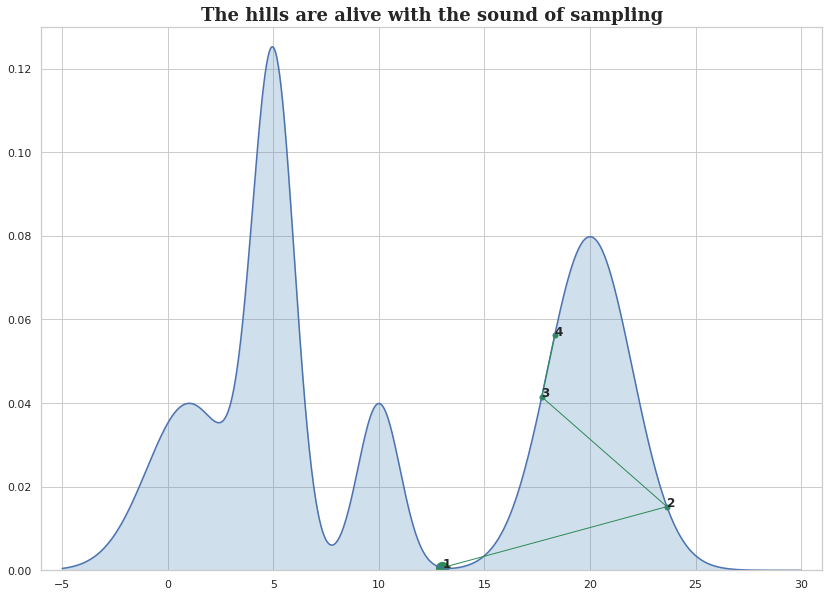

In [327]:
# plot the steps on the PDF
plt.figure(figsize=(14,10))
plt.plot(x,y)
plt.fill_between(x,np.zeros(len(x)),y,color='steelblue',alpha=0.25)
plt.plot(mixture_walk,y_walk,lw=1,color='seagreen')
plt.scatter(mixture_walk,y_walk,lw=1,s=25,color='seagreen')
plt.ylim(0,0.13)
plt.xlim(-6,31)

# where do we start?
plt.scatter(mixture_walk[0],y_walk[0],s=150,color='seagreen')
plt.text(mixture_walk[0],y_walk[0],str(1),fontweight='bold')

for i in range(1,len(mixture_walk)):
    if mixture_walk[i] != mixture_walk[i-1]:
        plt.text(mixture_walk[i],y_walk[i],str(i+1),fontweight='bold')

plt.title('The hills are alive with the sound of sampling',fontsize=18,fontfamily='serif',fontweight='bold');

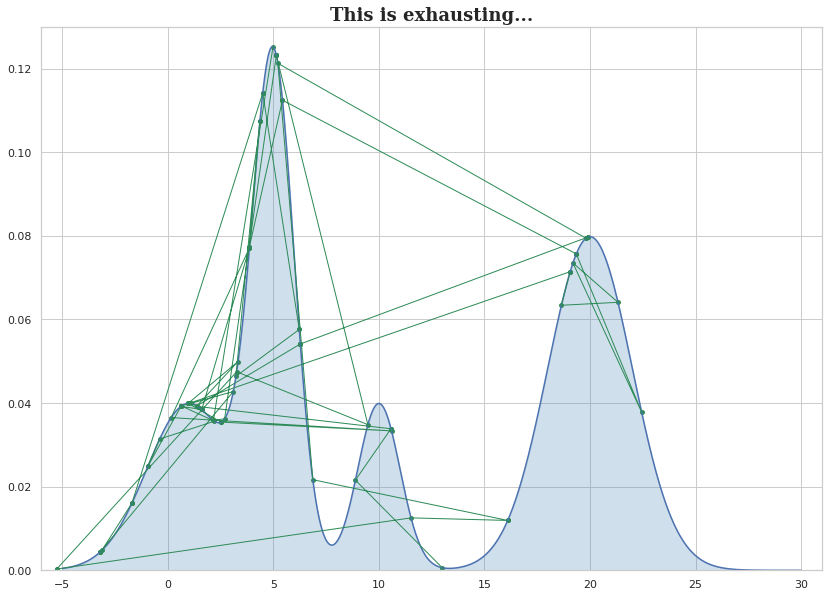

In [329]:
# a few more steps
mixture_walk = funky_walk(p_mixture,pdfs,13,8,100)

# where does it visit?
y_walk = p_mixture(mixture_walk,pdfs)

# plot
plt.figure(figsize=(14,10))
plt.plot(x,y)
plt.fill_between(x,np.zeros(len(x)),y,color='steelblue',alpha=0.25)
plt.plot(mixture_walk,y_walk,lw=1,color='seagreen')
plt.scatter(mixture_walk,y_walk,lw=1,s=15,color='seagreen')
plt.ylim(0,0.13)
plt.xlim(-6,31)

plt.title('This is exhausting...',fontsize=18,fontfamily='serif',fontweight='bold');

#### How does MCMC perform?

In [410]:
# 100 steps
mixture_walk = funky_walk(p_mixture,pdfs,10,0.5,100)

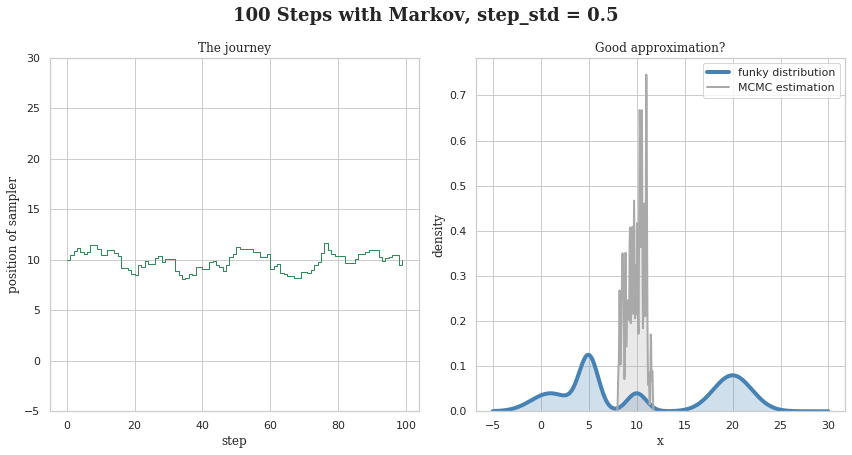

In [411]:
plot_sampler(mixture_walk,0.5)

In [412]:
# 100 steps
mixture_walk = funky_walk(p_mixture,pdfs,10,5,100)

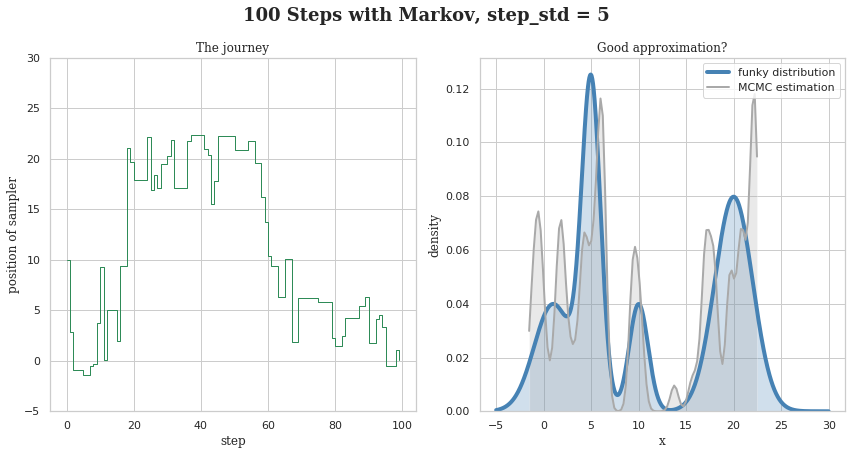

In [413]:
plot_sampler(mixture_walk,5)

In [414]:
# 1,000 steps
mixture_walk = funky_walk(p_mixture,pdfs,10,1,1000)

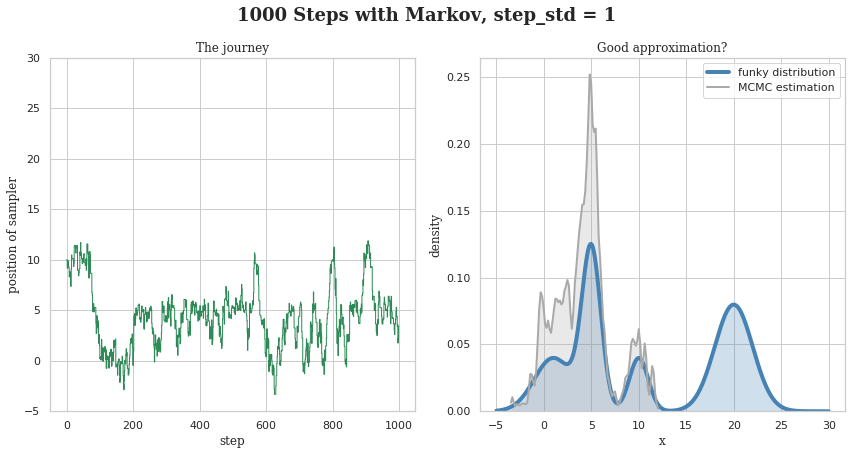

In [415]:
plot_sampler(mixture_walk,1)

In [416]:
# 1,000 steps
mixture_walk = funky_walk(p_mixture,pdfs,10,8,1000)

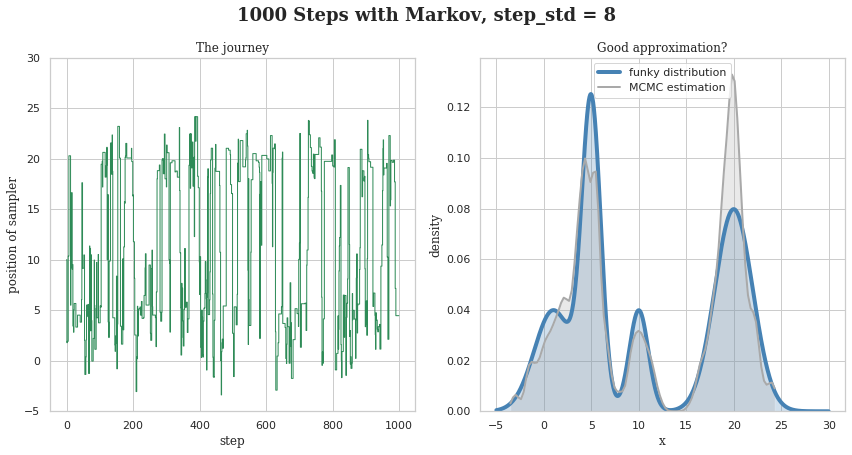

In [417]:
plot_sampler(mixture_walk,8)

## Defining this more formally


**Random Walk Metropolis Algorithm**


1. Generate a random starting location, $\theta_0$


2. Iterate the following steps for $t = 1, \ldots T$:

    a. Propose a new location $\theta_{t+1} \, \sim \, J(\theta_{t+1} | \theta_{t})$
    
    b. Calculate the ratio: $r = \frac{L(\theta_{t+1}) \mathrm{prior}(\theta_{t+1})}{L(\theta_{t}) \mathrm{prior}(\theta_{t})}$
    
    c. Compare $r$ with a uniformly-distributed number $u$ between 0 and 1.
    
    d. If $r \geq u$, then we move.
    
    e. Otherwise, we remain at our current position.

**Things to note about this algorithm**

1. Under quite general conditions the Random Walk Metropolis sampler converges asymptotically to the posterior.

2. However for a sufficiently large sample size the sampling distribution may be practically indistinguishable from the true posterior.

3. The ratio $r$ uses only the numerator of Bayes' rule...we do not need to calculate the denominator.

4. The path of positions, $\theta$, over time forms our sample.

**How does step size affect the algorithm?**

* The step size does not affect _asymptotic_ convergence, but who has time for that?

* When the step size is too small, it can take a very long time to find all areas of high probability mass.

* If the step size is too large, we find the typical set of values, but do not explore it efficiently.

* Most modern MCMC algorithms tune the step size during initial steps of the sampler.

**How do we know the sampler is done?**

* If we stop the sampler too early, then we can't say we are sampling from the posterior. Recall the example above with a small step size. We mapped out only one region at the end of the sampler.

* What do we mean by "done"? We mean the sampling distribution approximates the posterior distribution.

* Ideally we could judge the samples against the posterior, but, we don't have the posterior!

Instead we monitor whether the sampler is "settling in", ie reaching a stationary distribution. 

* By design, statisticians know that the stationary distribution of the Metropolis algorithm is the posterior.

* So how does this work?

### Monitoring convergence with multiple chains

* Start a number of chains in random dispersed locations in $\theta$ space.


* Chains do not interact with one another (in Metropolis).


* Run each sampler until it is hard to distinguish one chain’s path from all others’.

### We measure within-chain and between chain variability to assess convergence

Luckily statisticians have worked this out for us. Suppose we have $m$ chains, and $n$ draws from each chain.

To assess convergence we look at:

1. **within-chain variability**: how do the chains vary over the $n$ draws? Compute the mean of the variances of all the chains: 

   $W = \frac{1}{m} \sum_{j=1}^{m} \mathrm{var}(\theta_{j})$


2. **between-chain variability**: how do the chains vary across each other? Compute the squared difference from the mean value of $\theta$ across all chains: 

   $B = \frac{n}{m-1} \sum_{j=1}^{m} (\bar{\theta}_{j} - \bar{\theta})^2$
   
   
We put $W$ and $B$ together in the formula below:

  $\hat{R} = \sqrt{\frac{W + (1/n) * (B - W)}{W}}$
  
 
As $\hat{R} \rightarrow 1$ the chains start to converge. (In practice, look for $\hat{R} < 1.1$.)

In [342]:
def within_chain_var(chains):
    """
    given a dictionary of MCMC chains,
    compute within chain variability
    """
    v = []
    
    for c in chains.keys():
        v.append(np.var(chains[c]))
    
    return np.mean(v)

In [351]:
def between_chain_var(chains):
    """
    given a dictionary of MCMC chains,
    compute between chain variability
    """
    
    # setup
    n = len(chains[list(chains.keys())[0]])
    m = len(chains.keys())
    theta = []
    indv_means = np.zeros(len(chains.keys()))
    
    # compute means of individual chains
    for c in chains.keys():
        indv_means[c] = np.mean(chains[c]) 
        theta.append(chains[c])
    
    # compute mean of all chains
    theta = np.hstack(theta)
    mean_theta = np.mean(theta)
    
    # compute mean squared error
    B = 0
    for c in chains.keys():
        B += (indv_means[c] - mean_theta)**2
    
    return (n)/(m-1)*B

In [345]:
def convergence_stat(B,W,n):
    """
    compute the convergence statistic R-hat
    given the between and within chain variation
    and the length of each chain
    """
    return np.sqrt((W + (1/n)*(B - W))/(W))

In [425]:
# now let's start 4 chains and save the results

walkin_around = {}

walkin_around[0] = funky_walk(p_mixture,pdfs,0,1,1500)
walkin_around[1] = funky_walk(p_mixture,pdfs,5,1,1500)
walkin_around[2] = funky_walk(p_mixture,pdfs,10,1,1500)
walkin_around[3] = funky_walk(p_mixture,pdfs,20,1,1500)

In [426]:
# let's use only the last 1000 draws for the convergence statistics
num_postr_draws = 1000
trim_walkin_around = {}

for k in walkin_around.keys():
    trim_walkin_around[k] = walkin_around[k][:-num_postr_draws]

In [427]:
# compute components of r_hat
w_stat = within_chain_var(trim_walkin_around)
b_stat = between_chain_var(trim_walkin_around)
r_hat = convergence_stat(b_stat,w_stat,num_postr_draws)

In [428]:
# is r_hat less than 1.1?
r_hat

2.5454423488460534

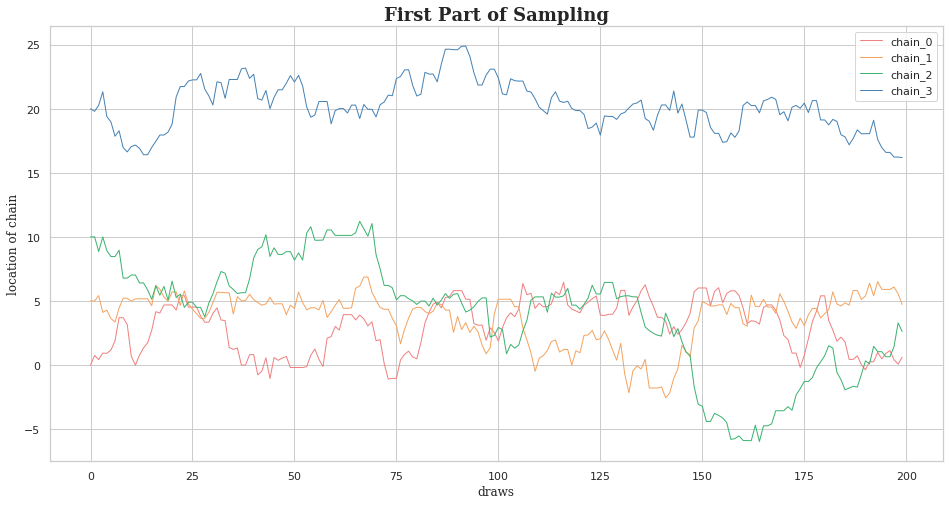

In [429]:
plt.figure(figsize=(16,8))
plt.plot(walkin_around[0][:200],lw=1,color='lightcoral',label='chain_0')
plt.plot(walkin_around[1][:200],lw=1,color='sandybrown',label='chain_1')
plt.plot(walkin_around[2][:200],lw=1,color='mediumseagreen',label='chain_2')
plt.plot(walkin_around[3][:200],lw=1,color='steelblue',label='chain_3')
plt.xlabel('draws',fontfamily='serif')
plt.ylabel('location of chain',fontfamily='serif')
plt.title('First Part of Sampling',fontsize=18,fontfamily='serif',fontweight='bold')
plt.legend();

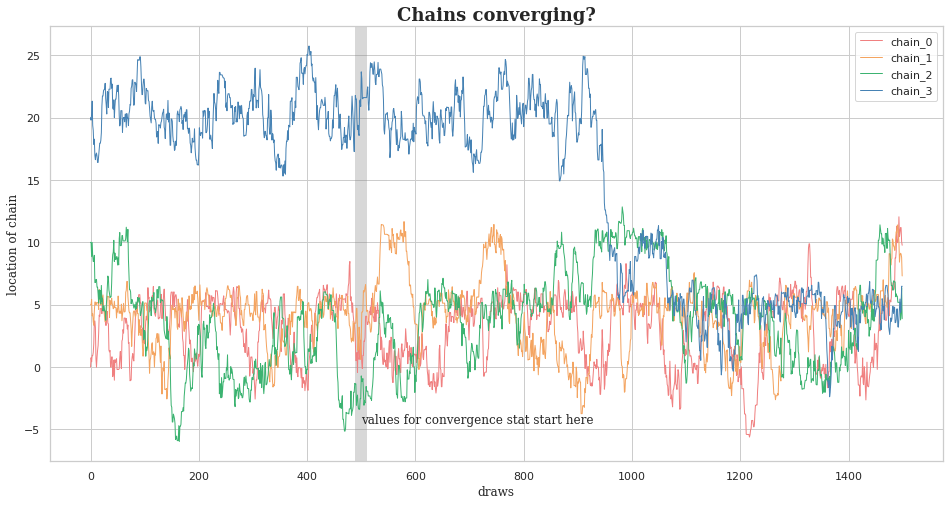

In [433]:
plt.figure(figsize=(16,8))
plt.axvline(500,color='gray',alpha=0.3,lw=12)
plt.text(500,-4.5,'values for convergence stat start here',fontfamily='serif')
plt.plot(walkin_around[0],lw=1,color='lightcoral',label='chain_0')
plt.plot(walkin_around[1],lw=1,color='sandybrown',label='chain_1')
plt.plot(walkin_around[2],lw=1,color='mediumseagreen',label='chain_2')
plt.plot(walkin_around[3],lw=1,color='steelblue',label='chain_3')
plt.xlabel('draws',fontfamily='serif')
plt.ylabel('location of chain',fontfamily='serif')
plt.title('Chains converging?',fontsize=18,fontfamily='serif',fontweight='bold')
plt.legend();

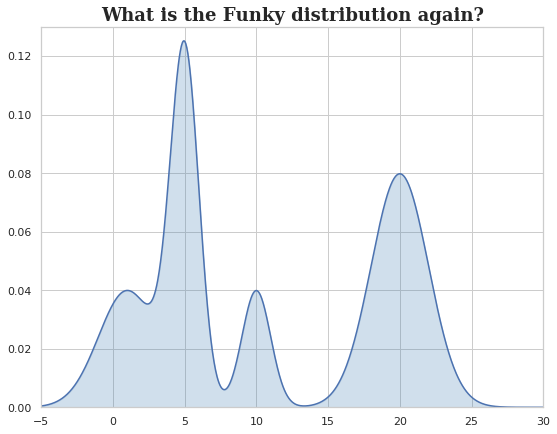

In [405]:
plt.figure(figsize=(9,7))
plt.plot(x,y)
plt.ylim(0,0.13)
plt.xlim(-5,30)
plt.fill_between(x,np.zeros(len(x)),y,color='steelblue',alpha=0.25)
plt.title('What is the Funky distribution again?',fontsize=18,fontfamily='serif',fontweight='bold');